In [4]:
%%writefile practice7.cu

#include <cuda_runtime.h> // подключает CUDA
#include <iostream> // подключает вывод
#include <vector> // подключает vector
#include <chrono> // подключает время CPU
#include <fstream> // подключает запись в файл
#include <cstdlib> // подключает rand

using namespace std; // чтобы не писать std::

void cuda_ok(cudaError_t err, const char* msg) { // проверка ошибок CUDA
    if (err != cudaSuccess) { // если ошибка
        cout << "CUDA error (" << msg << "): " << cudaGetErrorString(err) << endl; // печатает текст ошибки
        exit(1); // завершает программу
    }
}

__global__ void reduce_kernel(const int* in, int* block_sums, int N) { // редукция суммы по блокам
    extern __shared__ int sh[]; // shared память
    int tid = threadIdx.x; // индекс потока
    int gid = blockIdx.x * blockDim.x + tid; // глобальный индекс
    int x = 0; // значение элемента
    if (gid < N) x = in[gid]; // читает элемент если в пределах
    sh[tid] = x; // кладёт в shared память
    __syncthreads(); // синхронизация
    for (int stride = blockDim.x / 2; stride > 0; stride /= 2) { // шаги редукции
        if (tid < stride) { // работает половина потоков
            sh[tid] += sh[tid + stride]; // складывает элементы
        }
        __syncthreads(); // синхронизация
    }
    if (tid == 0) { // первый поток
        block_sums[blockIdx.x] = sh[0]; // записывает сумму блока
    }
}

__global__ void scan_block_exclusive_kernel(const int* in, int* out, int* block_sums, int N) { // exclusive scan внутри блока
    extern __shared__ int sh[]; // shared память
    int tid = threadIdx.x; // поток
    int gid = blockIdx.x * blockDim.x + tid; // глобальный индекс
    int x = 0; // значение
    if (gid < N) x = in[gid]; // читает элемент
    sh[tid] = x; // кладёт в shared
    __syncthreads(); // синхронизация

    for (int offset = 1; offset < blockDim.x; offset <<= 1) { // Hillis-Steele (inclusive)
        int val = 0; // временно
        if (tid >= offset) val = sh[tid - offset]; // берёт левый элемент
        __syncthreads(); // ждёт чтение
        sh[tid] += val; // обновляет значение
        __syncthreads(); // ждёт обновление
    }

    int inclusive = sh[tid]; // inclusive значение
    int exclusive = inclusive - x; // exclusive значение
    if (gid < N) out[gid] = exclusive; // пишет в выход

    if (tid == blockDim.x - 1) { // последний поток блока
        block_sums[blockIdx.x] = sh[tid]; // сохраняет сумму блока
    }
}

__global__ void add_offsets_kernel(int* out, const int* block_offsets, int N) { // добавляет оффсеты блоков
    int gid = blockIdx.x * blockDim.x + threadIdx.x; // глобальный индекс
    if (gid < N) { // если в пределах
        out[gid] += block_offsets[blockIdx.x]; // прибавляет оффсет блока
    }
}

long long cpu_reduce_sum(const vector<int>& a) { // CPU редукция суммы
    long long s = 0; // сумма
    for (int i = 0; i < (int)a.size(); i++) { // цикл
        s += a[i]; // прибавляет элемент
    }
    return s; // возвращает сумму
}

void cpu_exclusive_scan(const vector<int>& a, vector<int>& out) { // CPU exclusive scan
    long long run = 0; // накопленная сумма
    for (int i = 0; i < (int)a.size(); i++) { // цикл
        out[i] = (int)run; // записывает exclusive
        run += a[i]; // накапливает
    }
}

bool check_scan_head_100(const vector<int>& cpu_scan, const vector<int>& gpu_head) { // проверка первых 100 элементов
    for (int i = 0; i < 100; i++) { // цикл
        if (cpu_scan[i] != gpu_head[i]) return false; // если отличается
    }
    return true; // всё совпало
}

float gpu_reduce_sum_time_ms(const int* d_in, int N, long long& out_sum) { // GPU редукция + время
    int threads = 256; // потоки
    int blocks = (N + threads - 1) / threads; // блоки

    int* d_block_sums = nullptr; // суммы блоков на GPU
    cuda_ok(cudaMalloc(&d_block_sums, blocks * (int)sizeof(int)), "malloc d_block_sums reduce"); // malloc

    cudaEvent_t e1, e2; // события
    cuda_ok(cudaEventCreate(&e1), "event create reduce start"); // create
    cuda_ok(cudaEventCreate(&e2), "event create reduce end"); // create

    cuda_ok(cudaEventRecord(e1), "event record reduce start"); // старт таймера

    reduce_kernel<<<blocks, threads, threads * sizeof(int)>>>(d_in, d_block_sums, N); // запуск редукции
    cuda_ok(cudaGetLastError(), "reduce kernel launch"); // проверка запуска
    cuda_ok(cudaDeviceSynchronize(), "reduce sync"); // ждёт GPU

    cuda_ok(cudaEventRecord(e2), "event record reduce end"); // конец таймера
    cuda_ok(cudaEventSynchronize(e2), "event sync reduce end"); // ждёт событие

    float ms = 0.0f; // миллисекунды
    cuda_ok(cudaEventElapsedTime(&ms, e1, e2), "elapsed reduce"); // считает время

    vector<int> h_block_sums(blocks); // суммы блоков на CPU
    cuda_ok(cudaMemcpy(h_block_sums.data(), d_block_sums, blocks * (int)sizeof(int), cudaMemcpyDeviceToHost), "copy block sums reduce"); // копирует

    long long s = 0; // итоговая сумма
    for (int i = 0; i < blocks; i++) { // цикл
        s += h_block_sums[i]; // складывает блоки
    }
    out_sum = s; // сохраняет итог

    cuda_ok(cudaFree(d_block_sums), "free d_block_sums reduce"); // free
    cuda_ok(cudaEventDestroy(e1), "destroy reduce start"); // destroy
    cuda_ok(cudaEventDestroy(e2), "destroy reduce end"); // destroy

    return ms; // возвращает время
}

float gpu_scan_time_ms(const int* d_in, int N, int* d_out) { // GPU scan + время
    int threads = 256; // потоки
    int blocks = (N + threads - 1) / threads; // блоки

    int* d_block_sums = nullptr; // суммы блоков
    cuda_ok(cudaMalloc(&d_block_sums, blocks * (int)sizeof(int)), "malloc d_block_sums scan"); // malloc

    cudaEvent_t e1, e2; // события
    cuda_ok(cudaEventCreate(&e1), "event create scan start"); // create
    cuda_ok(cudaEventCreate(&e2), "event create scan end"); // create

    cuda_ok(cudaEventRecord(e1), "event record scan start"); // старт таймера

    scan_block_exclusive_kernel<<<blocks, threads, threads * sizeof(int)>>>(d_in, d_out, d_block_sums, N); // scan внутри блоков
    cuda_ok(cudaGetLastError(), "scan kernel launch"); // проверка запуска
    cuda_ok(cudaDeviceSynchronize(), "scan sync"); // ждёт GPU

    vector<int> h_block_sums(blocks); // суммы блоков на CPU
    cuda_ok(cudaMemcpy(h_block_sums.data(), d_block_sums, blocks * (int)sizeof(int), cudaMemcpyDeviceToHost), "copy block sums scan"); // копирует

    vector<int> h_block_offsets(blocks); // оффсеты блоков
    int run = 0; // накопленная сумма блоков
    for (int i = 0; i < blocks; i++) { // цикл
        h_block_offsets[i] = run; // оффсет текущего блока
        run += h_block_sums[i]; // добавляет сумму блока
    }

    int* d_block_offsets = nullptr; // оффсеты на GPU
    cuda_ok(cudaMalloc(&d_block_offsets, blocks * (int)sizeof(int)), "malloc d_block_offsets"); // malloc
    cuda_ok(cudaMemcpy(d_block_offsets, h_block_offsets.data(), blocks * (int)sizeof(int), cudaMemcpyHostToDevice), "copy block offsets"); // копирует оффсеты

    add_offsets_kernel<<<blocks, threads>>>(d_out, d_block_offsets, N); // добавляет оффсеты
    cuda_ok(cudaGetLastError(), "add offsets launch"); // проверка запуска
    cuda_ok(cudaDeviceSynchronize(), "add offsets sync"); // ждёт GPU

    cuda_ok(cudaEventRecord(e2), "event record scan end"); // конец таймера
    cuda_ok(cudaEventSynchronize(e2), "event sync scan end"); // ждёт событие

    float ms = 0.0f; // миллисекунды
    cuda_ok(cudaEventElapsedTime(&ms, e1, e2), "elapsed scan"); // считает время

    cuda_ok(cudaFree(d_block_sums), "free d_block_sums scan"); // free
    cuda_ok(cudaFree(d_block_offsets), "free d_block_offsets"); // free
    cuda_ok(cudaEventDestroy(e1), "destroy scan start"); // destroy
    cuda_ok(cudaEventDestroy(e2), "destroy scan end"); // destroy

    return ms; // возвращает время
}

int main() {
    srand(123); // фиксирует rand

    cout << "Practice 7: reduction + scan" << endl; // заголовок

    vector<int> sizes = {1024, 1000000, 10000000}; // размеры массива

    ofstream csv("results.csv"); // открывает CSV файл
    csv << "n,cpu_reduce_ms,gpu_reduce_ms,cpu_scan_ms,gpu_scan_ms,sum_ok,scan_head100_ok\n"; // заголовки

    for (int N : sizes) { // цикл по размерам
        vector<int> h_in(N); // массив на CPU
        for (int i = 0; i < N; i++) { // заполняет массив
            h_in[i] = rand() % 10; // случайные числа
        }

        vector<int> cpu_scan_out(N); // scan результат CPU

        auto c1 = chrono::high_resolution_clock::now(); // старт CPU reduce
        long long cpu_sum = cpu_reduce_sum(h_in); // CPU сумма
        auto c2 = chrono::high_resolution_clock::now(); // конец CPU reduce
        double cpu_reduce_ms = chrono::duration<double, std::milli>(c2 - c1).count(); // ms

        auto c3 = chrono::high_resolution_clock::now(); // старт CPU scan
        cpu_exclusive_scan(h_in, cpu_scan_out); // CPU scan
        auto c4 = chrono::high_resolution_clock::now(); // конец CPU scan
        double cpu_scan_ms = chrono::duration<double, std::milli>(c4 - c3).count(); // ms

        int* d_in = nullptr; // вход на GPU
        int* d_out = nullptr; // выход scan на GPU
        cuda_ok(cudaMalloc(&d_in, N * (int)sizeof(int)), "malloc d_in"); // malloc
        cuda_ok(cudaMalloc(&d_out, N * (int)sizeof(int)), "malloc d_out"); // malloc

        cuda_ok(cudaMemcpy(d_in, h_in.data(), N * (int)sizeof(int), cudaMemcpyHostToDevice), "copy in"); // копирует вход

        long long gpu_sum = 0; // сумма GPU
        float gpu_reduce_ms = gpu_reduce_sum_time_ms(d_in, N, gpu_sum); // GPU reduce + время
        float gpu_scan_ms = gpu_scan_time_ms(d_in, N, d_out); // GPU scan + время

        bool sum_ok = (cpu_sum == gpu_sum); // проверка суммы

        vector<int> gpu_head(100); // первые 100 элементов GPU scan
        cuda_ok(cudaMemcpy(gpu_head.data(), d_out, 100 * (int)sizeof(int), cudaMemcpyDeviceToHost), "copy scan head"); // копирует первые 100
        bool scan_ok = check_scan_head_100(cpu_scan_out, gpu_head); // проверка первых 100

        cout << "N = " << N << endl; // вывод размера
        cout << "CPU reduce ms = " << cpu_reduce_ms << endl; // вывод CPU reduce
        cout << "GPU reduce ms = " << gpu_reduce_ms << endl; // вывод GPU reduce
        cout << "CPU scan ms = " << cpu_scan_ms << endl; // вывод CPU scan
        cout << "GPU scan ms = " << gpu_scan_ms << endl; // вывод GPU scan
        cout << "sum ok = " << (sum_ok ? "yes" : "no") << endl; // вывод проверки суммы
        cout << "scan head100 ok = " << (scan_ok ? "yes" : "no") << endl; // вывод проверки scan
        cout << endl; // пустая строка

        csv << N << "," << cpu_reduce_ms << "," << gpu_reduce_ms << "," << cpu_scan_ms << "," << gpu_scan_ms << "," << (sum_ok ? 1 : 0) << "," << (scan_ok ? 1 : 0) << "\n"; // запись строки CSV

        cuda_ok(cudaFree(d_in), "free d_in"); // free
        cuda_ok(cudaFree(d_out), "free d_out"); // free
    }

    csv.close(); // закрывает CSV
    cout << "Saved: results.csv" << endl; // сообщает про файл

    return 0; // конец
}


Overwriting practice7.cu


In [5]:
%%bash
nvcc -O2 -gencode arch=compute_75,code=sm_75 practice7.cu -o practice7
./practice7


Practice 7: reduction + scan
N = 1024
CPU reduce ms = 0.000594
GPU reduce ms = 0.142368
CPU scan ms = 0.000549
GPU scan ms = 0.066496
sum ok = yes
scan head100 ok = yes

N = 1000000
CPU reduce ms = 0.451128
GPU reduce ms = 0.112448
CPU scan ms = 0.549701
GPU scan ms = 0.216224
sum ok = yes
scan head100 ok = yes

N = 10000000
CPU reduce ms = 5.59362
GPU reduce ms = 0.988416
CPU scan ms = 6.95973
GPU scan ms = 1.73312
sum ok = yes
scan head100 ok = yes

Saved: results.csv


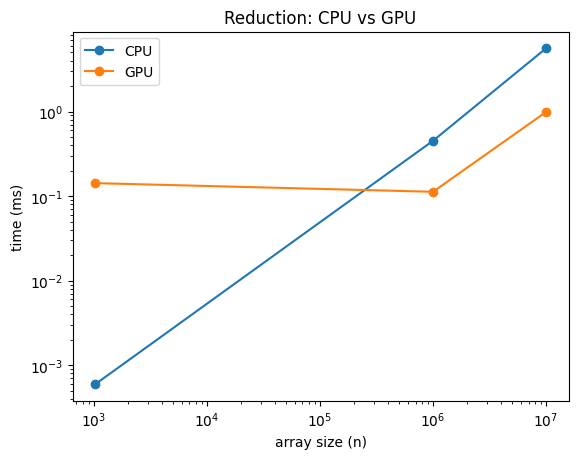

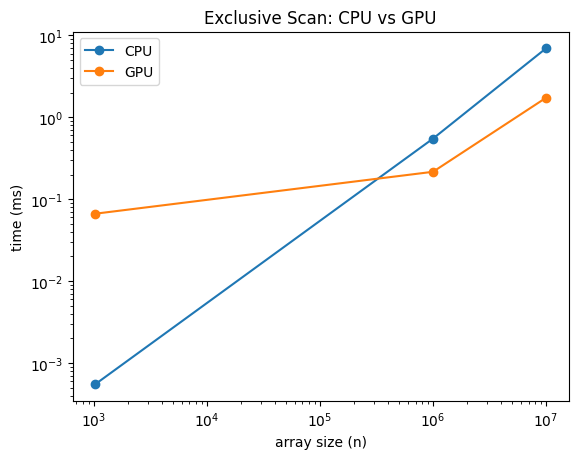

,n,cpu_reduce_ms,gpu_reduce_ms,cpu_scan_ms,gpu_scan_ms,sum_ok,scan_head100_ok
0,1024,0.000594,0.142368,0.000549,0.066496,1,1
1,1000000,0.451128,0.112448,0.549701,0.216224,1,1
2,10000000,5.593620,0.988416,6.959730,1.733120,1,1


In [6]:
import pandas as pd # читает таблицу
import matplotlib.pyplot as plt # строит графики

df = pd.read_csv("results.csv") # читает CSV

plt.figure() # новый график
plt.plot(df["n"], df["cpu_reduce_ms"], marker="o") # линия CPU reduce
plt.plot(df["n"], df["gpu_reduce_ms"], marker="o") # линия GPU reduce
plt.xscale("log") # лог шкала по X
plt.yscale("log") # лог шкала по Y
plt.xlabel("array size (n)") # подпись X
plt.ylabel("time (ms)") # подпись Y
plt.title("Reduction: CPU vs GPU") # заголовок
plt.legend(["CPU", "GPU"]) # легенда
plt.show() # показать

plt.figure() # новый график
plt.plot(df["n"], df["cpu_scan_ms"], marker="o") # линия CPU scan
plt.plot(df["n"], df["gpu_scan_ms"], marker="o") # линия GPU scan
plt.xscale("log") # лог шкала по X
plt.yscale("log") # лог шкала по Y
plt.xlabel("array size (n)") # подпись X
plt.ylabel("time (ms)") # подпись Y
plt.title("Exclusive Scan: CPU vs GPU") # заголовок
plt.legend(["CPU", "GPU"]) # легенда
plt.show() # показать

df # показать таблицу
